In [1]:
import fatf
import fatf.utils.data.datasets as fatf_datasets
from scipy import stats 
import sklearn.ensemble
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
# %matplotlib notebook
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import matplotlib
import matplotlib.pyplot as plt
import operator as op
from functools import reduce

import time
import warnings

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [2]:
from matplotlib.patches import Ellipse
import math
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse

Automatically created module for IPython interactive environment


C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 

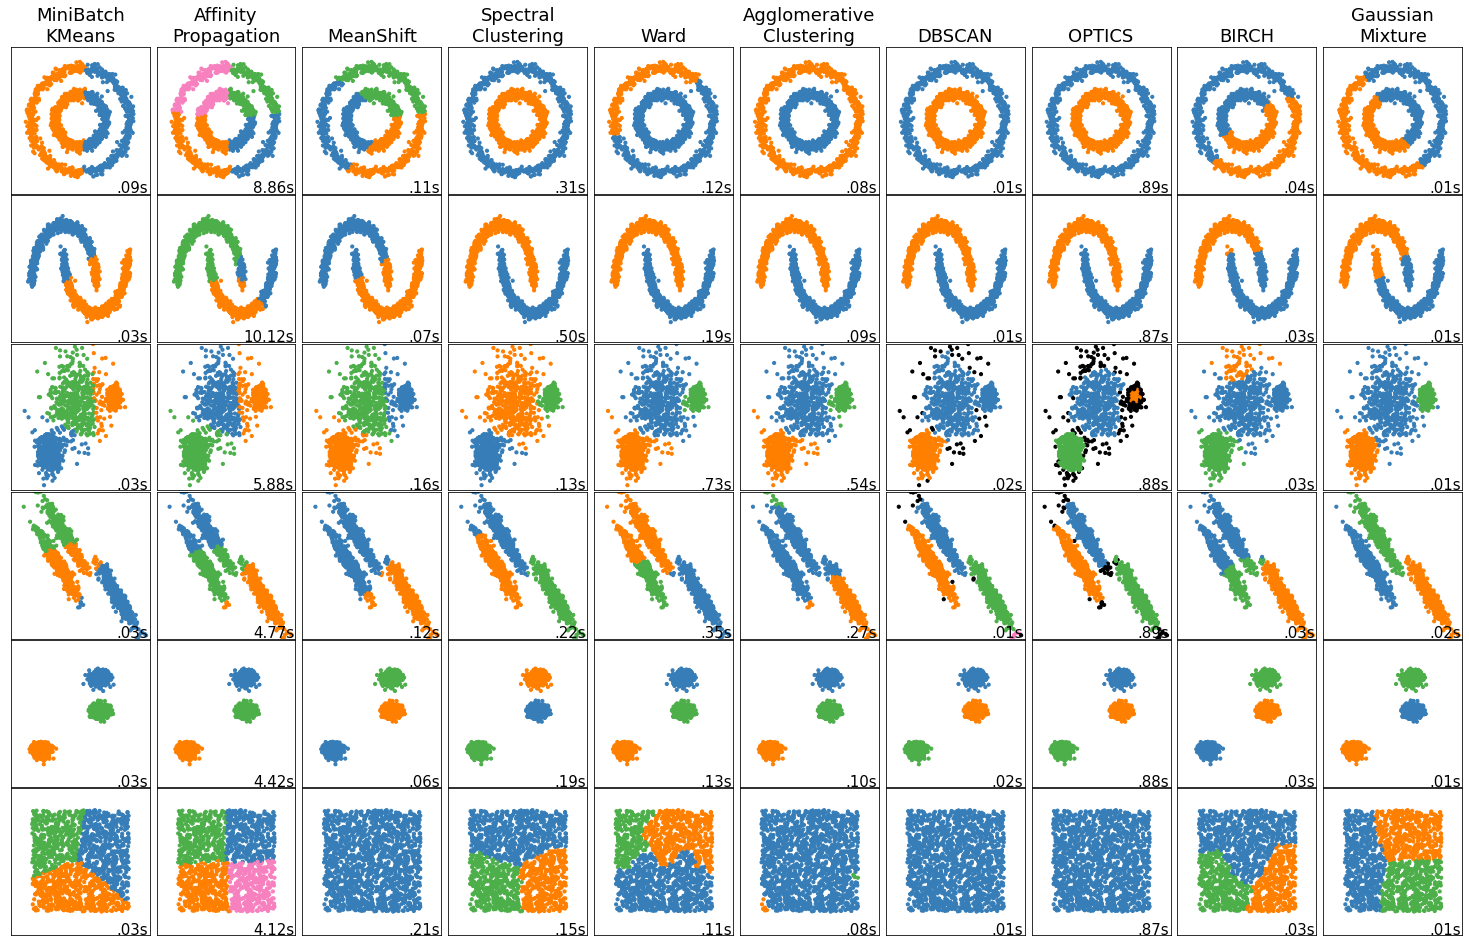

In [3]:
print(__doc__)

data_dictionary = {"Name":[],"Algorithm":[], "Data" : [] ,"Labels":[]}

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
            

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
        
        data_dictionary["Name"].append(name)
        data_dictionary["Algorithm"].append(algorithm)
        data_dictionary["Data"].append(X)
        data_dictionary["Labels"].append(y_pred)
        
        

plt.show()

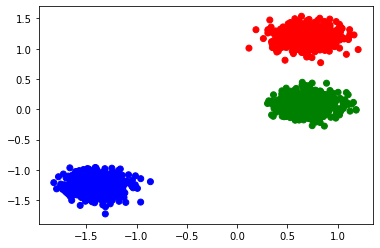

In [4]:
dataset = 40
labels = data_dictionary["Labels"][dataset]
data = data_dictionary["Data"][dataset]

colors = ['red', 'blue', 'green']

plt.scatter(data[:,0], data[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))

In [5]:
import sklearn.ensemble

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80)
blackbox_model = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
blackbox_model.fit(train, labels_train)
print('Train', sklearn.metrics.accuracy_score(labels_train, blackbox_model.predict(train)))
print('Test', sklearn.metrics.accuracy_score(labels_test, blackbox_model.predict(test)))

Train 1.0
Test 1.0


In [6]:
class GaussianMixtureModelsDiscretizer():
    
    def __init__(self, train, labels):
        self.train = train
        self.labels = labels

    
    def getLabels(self):
        train_label = []
        for lebel_number in set(self.labels):
            Classification = np.array([self.train[i] for i in range(len(self.labels)) if self.labels[i] == lebel_number])
            train_label.append(Classification)
        
        return train_label
    
    # BIC_range = make it an input??
    def gmmBIC(self, train_label_list, BIC_range = [1, 10]):
    
        all_gmm_list = []
        for class_C in train_label_list:
            gmm_list = []
            BIC_list = []
            for x in range(min(BIC_range), max(BIC_range) + 1):
                gmm = mixture.GaussianMixture(n_components= x, covariance_type='full').fit(class_C)
                BIC_list.append(gmm.bic(class_C))

            min_BIC_index = BIC_list.index(min(BIC_list))
            number_components = min_BIC_index + 1
            gmm = mixture.GaussianMixture(n_components=number_components, covariance_type='full').fit(class_C)
            gmm_list.append(gmm)

            all_gmm_list.append(gmm_list[0])

        return all_gmm_list
    
    def getIntervalsGmm(self, gmm, std_constant=3):
    
        width_interval_list = []
        height_interval_list = []
        pos_list = []
        angle_list = []

        # CHECK IF THIS WORKS FOR MORE THAN 2D, OTHERWISE CHANGE IT.
        for pos, covariance, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):

            if covariance.shape == (2, 2):
                U, s, Vt = np.linalg.svd(covariance)
                angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
                width, height = std_constant * np.sqrt(s)
            else:
                angle = 0
                width, height = std_constant * np.sqrt(covariance)



            width_interval_list.append(width)
            height_interval_list.append(height)
            pos_list.append(pos)
            angle_list.append(angle)

        return pos_list, width_interval_list, height_interval_list, angle_list
    
    
    def ellipseBoundingBox(self, pos_list, width_interval_list, height_interval_list, angle_list):
    
        x_intervals = []
        y_intervals = []
        for n in range(len(pos_list)):

            h = pos_list[n][0]
            k = pos_list[n][1]
            a = width_interval_list[n]
            b = height_interval_list[n]
            p = np.radians(angle_list[n])

            x_1_angle = np.arctan(-b*np.tan(p)/a)
            x_2_angle = np.arctan(-b*np.tan(p)/a) + math.pi

            y_1_angle = np.arctan(b/(a*np.tan(p)))
            y_2_angle = np.arctan(b/(a*np.tan(p))) + math.pi

            x_1 = h + a*np.cos(x_1_angle)*np.cos(p) - b*np.sin(x_1_angle)*np.sin(p)
            x_2 = h + a*np.cos(x_2_angle)*np.cos(p) - b*np.sin(x_2_angle)*np.sin(p)

            y_1 = k + b*np.sin(y_1_angle)*np.cos(p) + a*np.cos(y_1_angle)*np.sin(p)
            y_2 = k + b*np.sin(y_2_angle)*np.cos(p) + a*np.cos(y_2_angle)*np.sin(p)

            x_intervals.append([x_1, x_2])
            y_intervals.append([y_1, y_2])

        return x_intervals, y_intervals
     
    
    def getBoundingBoxesIntervals(self, list_gmm):
    
        x_intervals_list = []
        y_intervals_list = []
        for gmm in list_gmm:
            pos_list, width_interval_list, height_interval_list, angle_list = self.getIntervalsGmm(gmm)
            x_intervals, y_intervals = self.ellipseBoundingBox(pos_list, width_interval_list, height_interval_list, angle_list)

            x_intervals_list.append(x_intervals[0])
            y_intervals_list.append(y_intervals[0])
            
        
        x_flat_intervals_list = [interval for intervals in x_intervals_list for interval in intervals]
        y_flat_intervals_list = [interval for intervals in y_intervals_list for interval in intervals]
        x_flat_intervals_list.sort()
        y_flat_intervals_list.sort()

        feature_intervals_lists = [x_flat_intervals_list, y_flat_intervals_list]

        return feature_intervals_lists

    
    def discretizeFeature(self, feature_data_points, feature_interval_list):
    
        discretized_feature = []
        for feature_data_point in feature_data_points:
            
            if feature_data_point < feature_interval_list[0]:
                discretized_feature.append(0)
                
            elif  feature_interval_list[0] <= feature_data_point <= feature_interval_list[-1]:
                for i in range(1, len(feature_interval_list)):
                    if feature_interval_list[i-1] <= feature_data_point <= feature_interval_list[i]:
                        discretized_feature.append(i)
                        break       
            else:
                discretized_feature.append(len(x_flat_intervals_list))

        return discretized_feature

    
    def discretizeAllFeature(self, data, feature_intervals_lists):
    
        number_features = len(data[0])
        feature_list = []
        for i in range(number_features):
            feature_list.append(data[:, i])

        all_feature_discretize = []
        for feature, inteval in zip(feature_list, feature_intervals_lists):
            feature_discretize = self.discretizeFeature(feature, inteval)
            all_feature_discretize.append(feature_discretize)

        return np.column_stack(np.array(all_feature_discretize, dtype='f'))
       
        
    def discretize(self):
        
        train_label = self.getLabels()
        all_gmm_list = self.gmmBIC(train_label)
        feature_intervals_lists = self.getBoundingBoxesIntervals(all_gmm_list)
        all_feature_discretized = self.discretizeAllFeature(self.train, feature_intervals_lists)
        
        return all_feature_discretized

In [7]:
r1 = GaussianMixtureModelsDiscretizer(train = train, labels = labels_train)

In [8]:
r1.discretize()

C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans 

array([[4., 5.],
       [4., 3.],
       [4., 5.],
       ...,
       [4., 3.],
       [1., 1.],
       [4., 5.]], dtype=float32)

In [25]:
import lime
import lime.lime_tabular
import collections
import sklearn
import numpy as np
import os
import copy
import string
from io import open
import json
import matplotlib

In [26]:
"""  anchor_base.py 
     https://github.com/marcotcr/anchor/blob/master/anchor/anchor_base.py  """ 
from __future__ import print_function
# import numpy as np
import operator
import copy
# import sklearn
# import collections

""" Used in def get_anchor_from_tuple"""
def matrix_subset(matrix, n_samples):
    if matrix.shape[0] == 0:
        return matrix
    n_samples = min(matrix.shape[0], n_samples)
    return matrix[np.random.choice(matrix.shape[0], n_samples, replace=False)]

""" ~~~~ Used in calss AnchorTabularExplainer ~~~~ """
class AnchorBaseBeam(object):
    def __init__(self):
        pass
    
    """ KL divergence between two multivariate Bernoulli """
    
    """ Used in dlow_bernoulli """
    """The log likelihood ratio can be interpreted as the amount of evidence the data provide for one model versus another, 
        so the KL divergence tells us how much evidence we can expect our data to provide in favor of the true model."""
    
    """ D(P||D) = It a measure of how one probability distribution (P) is different from a second (Q)"""
    """ It is also called relative entropy """
    """ It is not the distance between two distribution- often misundestood """
    """ p and q are the probability distributions """
    """ p to q !=  q to p -> nonsymmetric """
    """ D(P||D) = is the information gain when distribution Q is used insted of distibution P """
    @staticmethod
    def kl_bernoulli(p, q):
        p = min(0.9999999999999999, max(0.0000001, p))
        q = min(0.9999999999999999, max(0.0000001, q))
        return (p * np.log(float(p) / q) + (1 - p) *
                np.log(float(1 - p) / (1 - q)))
    
    """ Used in anchor_beam """
    @staticmethod
    def compute_beta(n_features, t, delta):
        alpha = 1.1
        k = 405.5
        temp = np.log(k * n_features * (t ** alpha) / delta)
        return temp + np.log(temp)
    
    """ Used in lucb and anchor_beam """
    @staticmethod
    def dup_bernoulli(p, level):
        lm = p
        um = min(min(1, p + np.sqrt(level / 2.)), 1)
        qm = (um + lm) / 2.
#         print 'lm', lm, 'qm', qm, kl_bernoulli(p, qm)
        if AnchorBaseBeam.kl_bernoulli(p, qm) > level:
            um = qm
        else:
            lm = qm
        return um
    """ Used in anchor_beam """
    @staticmethod
    def lucb(sample_fns, initial_stats, epsilon, delta, batch_size, top_n,
             verbose=False, verbose_every=1):
        # initial_stats must have n_samples, positive
        n_features = len(sample_fns)
        n_samples = np.array(initial_stats['n_samples'])
        positives = np.array(initial_stats['positives'])
        ub = np.zeros(n_samples.shape)
        lb = np.zeros(n_samples.shape)
        for f in np.where(n_samples == 0)[0]:
            n_samples[f] += 1
            positives[f] += sample_fns[f](1)
        if n_features == top_n:
            return range(n_features)
        means = positives / n_samples
        t = 1

        def update_bounds(t):
            sorted_means = np.argsort(means)
            beta = AnchorBaseBeam.compute_beta(n_features, t, delta)
            J = sorted_means[-top_n:]
            not_J = sorted_means[:-top_n]
            for f in not_J:
                ub[f] = AnchorBaseBeam.dup_bernoulli(means[f], beta /
                                                     n_samples[f])
            for f in J:
                lb[f] = AnchorBaseBeam.dlow_bernoulli(means[f],
                                                      beta / n_samples[f])
            ut = not_J[np.argmax(ub[not_J])]
            lt = J[np.argmin(lb[J])]
            return ut, lt
        ut, lt = update_bounds(t)
        B = ub[ut] - lb[lt]
        verbose_count = 0
        while B > epsilon:
            verbose_count += 1
            if verbose and verbose_count % verbose_every == 0:
                print('Best: %d (mean:%.10f, n: %d, lb:%.4f)' %
                      (lt, means[lt], n_samples[lt], lb[lt]), end=' ')
                print('Worst: %d (mean:%.4f, n: %d, ub:%.4f)' %
                      (ut, means[ut], n_samples[ut], ub[ut]), end=' ')
                print('B = %.2f' % B)
            n_samples[ut] += batch_size
            positives[ut] += sample_fns[ut](batch_size)
            means[ut] = positives[ut] / n_samples[ut]
            n_samples[lt] += batch_size
            positives[lt] += sample_fns[lt](batch_size)
            means[lt] = positives[lt] / n_samples[lt]
            t += 1
            ut, lt = update_bounds(t)
            B = ub[ut] - lb[lt]
        sorted_means = np.argsort(means)
        return sorted_means[-top_n:]
    
    """ Used in anchor_beam """
    @staticmethod
    def dlow_bernoulli(p, level):
        um = p
        lm = max(min(1, p - np.sqrt(level / 2.)), 0)
        qm = (um + lm) / 2.
#         print 'lm', lm, 'qm', qm, kl_bernoulli(p, qm)
        if AnchorBaseBeam.kl_bernoulli(p, qm) > level:
            lm = qm
        
        else:
            um = qm
        return lm

    """ Used in anchor_beam """
    @staticmethod
    def make_tuples(previous_best, state):
        # alters state, computes support for new tuples
        normalize_tuple = lambda x: tuple(sorted(set(x)))  # noqa
        all_features = range(state['n_features'])
        coverage_data = state['coverage_data']
        current_idx = state['current_idx']
        data = state['data'][:current_idx]
        labels = state['labels'][:current_idx]
        
        """ len(previous_best) == 0 ->  first try"""
        if len(previous_best) == 0:
            tuples = [(x, ) for x in all_features]
#             print("all_features", all_features)
#             print("tuples", tuples)
            for x in tuples:
                pres = data[:, x[0]].nonzero()[0]
#                 print("pres", pres)
#                 print("float(len(pres)", float(len(pres)))
#                 print("float(labels[pres].sum())", float(labels[pres].sum()))
#                 print("x[0]", x[0])
                # NEW
                state['t_idx'][x] = set(pres)
                state['t_nsamples'][x] = float(len(pres))
                state['t_positives'][x] = float(labels[pres].sum())
                state['t_order'][x].append(x[0])
                # NEW
                state['t_coverage_idx'][x] = set(
                    coverage_data[:, x[0]].nonzero()[0])
                state['t_coverage'][x] = (
                    float(len(state['t_coverage_idx'][x])) /
                    coverage_data.shape[0])
            return tuples
#         print("")
        new_tuples = set()
        for f in all_features:
            for t in previous_best:
                new_t = normalize_tuple(t + (f, ))
                if len(new_t) != len(t) + 1:
                    continue
                if new_t not in new_tuples:
                    new_tuples.add(new_t)
                    state['t_order'][new_t] = copy.deepcopy(state['t_order'][t])
                    state['t_order'][new_t].append(f)
                    state['t_coverage_idx'][new_t] = (
                        state['t_coverage_idx'][t].intersection(
                            state['t_coverage_idx'][(f,)]))
                    state['t_coverage'][new_t] = (
                        float(len(state['t_coverage_idx'][new_t])) /
                        coverage_data.shape[0])
                    t_idx = np.array(list(state['t_idx'][t]))
                    t_data = state['data'][t_idx]
                    present = np.where(t_data[:, f] == 1)[0]
                    state['t_idx'][new_t] = set(t_idx[present])
                    idx_list = list(state['t_idx'][new_t])
                    state['t_nsamples'][new_t] = float(len(idx_list))
                    state['t_positives'][new_t] = np.sum(
                        state['labels'][idx_list])
        return list(new_tuples)
    
    """ Used in anchor_beam """
    @staticmethod
    def get_sample_fns(sample_fn, tuples, state):
        # each sample fn returns number of positives
        sample_fns = []
        def complete_sample_fn(t, n):
            raw_data, data, labels = sample_fn(list(t), n)
            current_idx = state['current_idx']
            # idxs = range(state['data'].shape[0], state['data'].shape[0] + n)
            idxs = range(current_idx, current_idx + n)
            state['t_idx'][t].update(idxs)
            state['t_nsamples'][t] += n
            state['t_positives'][t] += labels.sum()
            state['data'][idxs] = data
            state['raw_data'][idxs] = raw_data
            state['labels'][idxs] = labels
            state['current_idx'] += n
            if state['current_idx'] >= state['data'].shape[0] - max(1000, n):
                prealloc_size = state['prealloc_size']
                current_idx = data.shape[0]
                state['data'] = np.vstack(
                    (state['data'],
                     np.zeros((prealloc_size, data.shape[1]), data.dtype)))
                state['raw_data'] = np.vstack(
                    (state['raw_data'],
                     np.zeros((prealloc_size, raw_data.shape[1]),
                              raw_data.dtype)))
                state['labels'] = np.hstack(
                    (state['labels'],
                     np.zeros(prealloc_size, labels.dtype)))
            # This can be really slow
            # state['data'] = np.vstack((state['data'], data))
            # state['raw_data'] = np.vstack((state['raw_data'], raw_data))
            # state['labels'] = np.hstack((state['labels'], labels))
            return labels.sum()
        for t in tuples:
            sample_fns.append(lambda n, t=t: complete_sample_fn(t, n))
        
#         print("sample_fns", sample_fns)
        return sample_fns
    
    """ Used in anchor_beam """
    @staticmethod
    def get_initial_statistics(tuples, state):
        stats = {
            'n_samples': [],
            'positives': []
        }
        for t in tuples:
            stats['n_samples'].append(state['t_nsamples'][t])
            stats['positives'].append(state['t_positives'][t])
        return stats
    
    """ Used in anchor_beam """
    @staticmethod
    def get_anchor_from_tuple(t, state):
        # TODO: This is wrong, some of the intermediate anchors may not exist.
        anchor = {'feature': [], 'mean': [], 'precision': [],
                  'coverage': [], 'examples': [], 'all_precision': 0}
        anchor['num_preds'] = state['data'].shape[0]
        normalize_tuple = lambda x: tuple(sorted(set(x)))  # noqa
        current_t = tuple()
        for f in state['t_order'][t]:
            current_t = normalize_tuple(current_t + (f,))

            mean = (state['t_positives'][current_t] /
                    state['t_nsamples'][current_t])
            anchor['feature'].append(f)
            anchor['mean'].append(mean)
            anchor['precision'].append(mean)
            anchor['coverage'].append(state['t_coverage'][current_t])
            raw_idx = list(state['t_idx'][current_t])
            raw_data = state['raw_data'][raw_idx]
            covered_true = (
                state['raw_data'][raw_idx][state['labels'][raw_idx] == 1])
            covered_false = (
                state['raw_data'][raw_idx][state['labels'][raw_idx] == 0])
            exs = {}
            exs['covered'] = matrix_subset(raw_data, 10)
            exs['covered_true'] = matrix_subset(covered_true, 10)
            exs['covered_false'] = matrix_subset(covered_false, 10)
            exs['uncovered_true'] = np.array([])
            exs['uncovered_false'] = np.array([])
            anchor['examples'].append(exs)
        return anchor
    
    """ I think is where the best anchor is selected (using mult)"""
    @staticmethod
    def anchor_beam(sample_fn, delta=0.05, epsilon=0.1, batch_size=10,
                    min_shared_samples=0, desired_confidence=1, beam_size=1,
                    verbose=False, epsilon_stop=0.05, min_samples_start=0,
                    max_anchor_size=None, verbose_every=1,
                    stop_on_first=False, coverage_samples=10000):
        anchor = {'feature': [], 'mean': [], 'precision': [],
                  'coverage': [], 'examples': [], 'all_precision': 0}
        
        """ sample_fn returns: raw_data, data, labels
                raw_data = boostram samples. 
                data = array of 1 and 0, 1 if the train_dataset is <=, > or == to the rigion... 
                labels = array of 1 and 0, 1 if the predictions is the same as the true labels, 0 otherwise """
        """coverage_data =  array of 1000 list with 12 elements, each with 0 or 1"""
        _, coverage_data, _ = sample_fn([], coverage_samples, compute_labels=False)
        
#         print("coverage_data", coverage_data)
#         print("len(coverage_data)", len(coverage_data))
#         print("len(coverage_data[0])", len(coverage_data[0]))
        
        """max(1, min_samples_start) = max(1, 0) = 1"""
        """instance = [] """
        """ raw_data = one random boostrap example, data=[1 0 ... 0], labels = predictions"""
        raw_data, data, labels = sample_fn([], max(1, min_samples_start))
        
#         print("raw_data, data, labels", raw_data, data, labels)
        
        mean = labels.mean()
        beta = np.log(1. / delta)
#         print("beta / data.shape[0]", beta / data.shape[0])
        lb = AnchorBaseBeam.dlow_bernoulli(mean, beta / data.shape[0])
        print("mean", mean, "beta", beta, "lb", lb)
        
        """ desired_confidence = 1, epsilon = 0.1 """
        while mean > desired_confidence and lb < desired_confidence - epsilon:
            """batch_size=10 """
            """ nraw_data = 10 random boostrap example, ndata=[1 0 ... 0], nlabels = predictions"""
            nraw_data, ndata, nlabels = sample_fn([], batch_size)
#             print("nraw_data, ndata, nlabels", nraw_data, ndata, nlabels)
            """ stacks data, row_data and labels, I don't really undestand the point of this"""
            data = np.vstack((data, ndata))
            raw_data = np.vstack((raw_data, nraw_data))
            raw_data = np.vstack((raw_data, nraw_data))
            labels = np.hstack((labels, nlabels))
#             print("raw_data, data, labels", raw_data, data, labels)
            mean = labels.mean()
            lb = AnchorBaseBeam.dlow_bernoulli(mean, beta / data.shape[0])
            print('after: mean, lb', mean, lb)
        if lb > desired_confidence:
            anchor['num_preds'] = data.shape[0]
            anchor['all_precision'] = mean
            print("if lb > desired_confidence", lb > desired_confidence)
            print("anchor['num_preds']", anchor['num_preds'])
            print("anchor['all_precision']", anchor['all_precision'])
            return anchor
        
        """ batch_size = 10 -> prealloc_size = 100000 """
        prealloc_size = batch_size * 10000
        current_idx = data.shape[0]
        data = np.vstack((data, np.zeros((prealloc_size, data.shape[1]),
                                         data.dtype)))
        raw_data = np.vstack(
            (raw_data, np.zeros((prealloc_size, raw_data.shape[1]),
                                raw_data.dtype)))
        labels = np.hstack((labels, np.zeros(prealloc_size, labels.dtype)))
        n_features = data.shape[1]
        
#         print("prealloc_size", prealloc_size)
#         print("current_idx", current_idx)
#         print("data", data)
#         print("raw_data", raw_data)
#         print("labels", labels)
#         print("n_features", n_features)
        state = {'t_idx': collections.defaultdict(lambda: set()),
                 't_nsamples': collections.defaultdict(lambda: 0.),
                 't_positives': collections.defaultdict(lambda: 0.),
                 'data': data,
                 'prealloc_size': prealloc_size,
                 'raw_data': raw_data,
                 'labels': labels,
                 'current_idx': current_idx,
                 'n_features': n_features,
                 't_coverage_idx': collections.defaultdict(lambda: set()),
                 't_coverage': collections.defaultdict(lambda: 0.),
                 'coverage_data': coverage_data,
                 't_order': collections.defaultdict(lambda: list())
                 }
        current_size = 1
        best_of_size = {0: []}
        best_coverage = -1
        best_tuple = ()
        t = 1
        """ max_anchor_size = None, n_features= 12 (most of the times)"""
        if max_anchor_size is None:
            max_anchor_size = n_features
            
        """ current_size = 1 """
        while current_size <= max_anchor_size:
            """ makes tuples from all_features """
            tuples = AnchorBaseBeam.make_tuples(
                best_of_size[current_size - 1], state)
#             print("\n tuples before", tuples)
            tuples = [x for x in tuples
                      if state['t_coverage'][x] > best_coverage]
#             print("best_coverage", best_coverage)
#             print("tuples after", tuples, "\n")
            
            """ len(tuples) == 0 -> Non of new tubles have a lager coverage compared to the best one found preciously """
            if len(tuples) == 0:
                break
            
            sample_fns = AnchorBaseBeam.get_sample_fns(sample_fn, tuples,
                                                       state)
#             print("sample_fns", sample_fns)
            initial_stats = AnchorBaseBeam.get_initial_statistics(tuples, state)
#             print("initial_stats", initial_stats)
            
            # print tuples, beam_size
            
            """ still yet to undestand how this function works """
            chosen_tuples = AnchorBaseBeam.lucb(
                sample_fns, initial_stats, epsilon, delta, batch_size,
                min(beam_size, len(tuples)),
                verbose=verbose, verbose_every=verbose_every)
            print("chosen_tuples", chosen_tuples)
            
            best_of_size[current_size] = [tuples[x] for x in chosen_tuples]
            print("best_of_size[current_size]", best_of_size[current_size])
            
            """ Verbose =  False, Verbose that does this mean? """
            if verbose:
                print('Best of size ', current_size, ':')
            # print state['data'].shape[0]
            stop_this = False
            for i, t in zip(chosen_tuples, best_of_size[current_size]):
                # I can choose at most (beam_size - 1) tuples at each step,
                # and there are at most n_feature steps
                """ why does it chose this beta? """
                beta = np.log(1. /
                              (delta / (1 + (beam_size - 1) * n_features)))
                # beta = np.log(1. / delta)
                # if state['t_nsamples'][t] == 0:
                #     mean = 1
                # else:
                mean = state['t_positives'][t] / state['t_nsamples'][t]
                lb = AnchorBaseBeam.dlow_bernoulli(
                    mean, beta / state['t_nsamples'][t])
                ub = AnchorBaseBeam.dup_bernoulli(
                    mean, beta / state['t_nsamples'][t])
                coverage = state['t_coverage'][t]
                print("mean", mean)
                print("lb", lb)
                print("ub", ub)
                print("coverage", coverage)
                if verbose:
                    print(i, mean, lb, ub)
                while ((mean >= desired_confidence and
                       lb < desired_confidence - epsilon_stop) or
                       (mean < desired_confidence and
                        ub >= desired_confidence + epsilon_stop)):
                    # print mean, lb, state['t_nsamples'][t]
                    sample_fns[i](batch_size)
                    mean = state['t_positives'][t] / state['t_nsamples'][t]
                    lb = AnchorBaseBeam.dlow_bernoulli(
                        mean, beta / state['t_nsamples'][t])
                    ub = AnchorBaseBeam.dup_bernoulli(
                        mean, beta / state['t_nsamples'][t])
                if verbose:
                    print('%s mean = %.2f lb = %.2f ub = %.2f coverage: %.2f n: %d' % (t, mean, lb, ub, coverage, state['t_nsamples'][t]))
                if mean >= desired_confidence and lb > desired_confidence - epsilon_stop:
                    if verbose:
                        print('Found eligible anchor ', t, 'Coverage:',
                              coverage, 'Is best?', coverage > best_coverage)
                    if coverage > best_coverage:
                        best_coverage = coverage
                        best_tuple = t
                        if best_coverage == 1 or stop_on_first:
                            stop_this = True
            if stop_this:
                break
            current_size += 1
        if best_tuple == ():
            # Could not find an anchor, will now choose the highest precision
            # amongst the top K from every round
            if verbose:
                print('Could not find an anchor, now doing best of each size')
            tuples = []
            for i in range(0, current_size):
                tuples.extend(best_of_size[i])
            # tuples = best_of_size[current_size - 1]
            sample_fns = AnchorBaseBeam.get_sample_fns(sample_fn, tuples,
                                                       state)
            initial_stats = AnchorBaseBeam.get_initial_statistics(tuples,
                                                                  state)
            # print tuples, beam_size
            chosen_tuples = AnchorBaseBeam.lucb(
                sample_fns, initial_stats, epsilon, delta, batch_size,
                1, verbose=verbose)
            best_tuple = tuples[chosen_tuples[0]]
        # return best_tuple, state
        return AnchorBaseBeam.get_anchor_from_tuple(best_tuple, state)

In [27]:
from __future__ import print_function
import io


""" ~~~~~ Used in class AnchorBaseBeam(object): ~~~~~ """
class AnchorExplanation:
    """Object returned by explainers"""
    def __init__(self, type_, exp_map, as_html):
        self.type = type_
        self.exp_map = exp_map
        self.as_html_fn = as_html
    
    """ Not in the main code, just when printting the rages of the anchor's features"""
    def names(self, partial_index=None):
        """
        Returns a list of the names of the anchor conditions.
        Args:
            partial_index (int): lets you get the anchor until a certain index.
            For example, if the anchor is (A=1,B=2,C=2) and partial_index=1,
            this will return ["A=1", "B=2"]
        """
        names = self.exp_map['names']
        if partial_index is not None:
            names = names[:partial_index + 1]
        return names
    
    """ Not in the main code, returns the index of the anchor's features used"""
    def features(self, partial_index=None):
        """
        Returns a list of the features used in the anchor conditions.
        Args:
            partial_index (int): lets you get the anchor until a certain index.
            For example, if the anchor uses features (1, 2, 3) and
            partial_index=1, this will return [1, 2]
        """
        features = self.exp_map['feature']
        if partial_index is not None:
            features = features[:partial_index + 1]
        return features
    
    """ Not in the main code, returns precision of the anchor's"""
    def precision(self, partial_index=None):
        """
        Returns the anchor precision (a float)
        Args:
            partial_index (int): lets you get the anchor precision until a
            certain index. For example, if the anchor has precisions
            [0.1, 0.5, 0.95] and partial_index=1, this will return 0.5
        """
        precision = self.exp_map['precision']
        if len(precision) == 0:
            return self.exp_map['all_precision']
        if partial_index is not None:
            return precision[partial_index]
        else:
            return precision[-1]

    """ Not in the main code, returns coverage of the anchor's """
    def coverage(self, partial_index=None):
        """
        Returns the anchor coverage (a float)
        Args:
            partial_index (int): lets you get the anchor coverage until a
            certain index. For example, if the anchor has coverages
            [0.1, 0.5, 0.95] and partial_index=1, this will return 0.5
        """
        coverage = self.exp_map['coverage']
        if len(coverage) == 0:
            return 1
        if partial_index is not None:
            return coverage[partial_index]
        else:
            return coverage[-1]

In [72]:
""" anchor_tabular.py 
    https://github.com/marcotcr/anchor/blob/master/anchor/anchor_tabular.py"""

"""def as_html(, def jsonize(x)"""

def id_generator(size=15):
    """Helper function to generate random div ids. This is useful for embedding
    HTML into ipython notebooks."""
    chars = list(string.ascii_uppercase + string.digits)

    
    
""" This is the main class-file to compute the anchors for tabular data """
class AnchorTabularExplainer(object):
    """
        Args:
            class_names: list of strings
            feature_names: list of strings
            train_data: used to sample (bootstrap)
            categorical_names: map from integer to list of strings, names for each
                value of the categorical features. Every feature that is not in
                this map will be considered as ordinal or continuous, and thus discretized.
        """

    def __init__(self, class_names, feature_names, train_data, train_label = None,
                 categorical_names={}, discretizer='quartile', encoder_fn=None):
        self.min = {}
        self.max = {}
        self.disc = collections.namedtuple('random_name2',
                                              ['discretize'])(lambda x: x)
        self.encoder_fn = lambda x: x
        if encoder_fn is not None:
            self.encoder_fn = encoder_fn
        self.categorical_features = []
        self.feature_names = feature_names
        self.train = train_data
        self.class_names = class_names
        self.categorical_names = copy.deepcopy(categorical_names)
        if categorical_names:
            self.categorical_features = sorted(categorical_names.keys())

        if discretizer == 'quartile':
            self.disc = lime.lime_tabular.QuartileDiscretizer(train_data,
                                                         self.categorical_features,
                                                         self.feature_names)
            print("self.disc", self.disc)
        elif discretizer == 'decile':
            self.disc = lime.lime_tabular.DecileDiscretizer(train_data,
                                                     self.categorical_features,
                                                     self.feature_names)
            print("self.disc", self.disc)
        
        elif discretizer == 'GaussianMixtureModels':
            self.disc = GaussianMixtureModelsDiscretizer(train_data, train_label)
            
        else:
            raise ValueError('Discretizer must be quartile or decile')

        """ ?? """
        self.ordinal_features = [x for x in range(len(feature_names)) if x not in self.categorical_features]
        
        print("self.train", self.train)
#         self.d_train = self.disc.discretize(self.train)
        self.d_train = self.disc.discretize()
        print("self.d_train", self.d_train)
        print("self.d_train.type()", type(self.d_train))
        self.categorical_names.update(self.disc.names)
#         print("self.categorical_names", self.categorical_names)
        self.categorical_features += self.ordinal_features
#         print("self.categorical_features", self.categorical_features)

        """ selects the min and max in the training data set"""
        for f in range(train_data.shape[1]):
            self.min[f] = np.min(train_data[:, f])
            print("self.min[f]", self.min[f])
            self.max[f] = np.max(train_data[:, f])
            print("self.max[f]", self.max[f])
            
    
    """ This is def explain_instance: def sample_fn """
    """Randomelly selects with replacement from the training dataset where feature is > the saved reagio
                     and samples as many samples from the boostrap <=  to the saved reagion """
    def sample_from_train(self, conditions_eq, conditions_neq, conditions_geq,
                          conditions_leq, num_samples):
        """
        bla
        """
        """ Train the list of training input dataset, d_train is the discretized training input datset."""
        train = self.train
        d_train = self.d_train
        
        """train.shape[0]=len(train)=120, , with replacement --> boostrap, 
            selects n (= num_samples) indexes from the train dataset with replacement"""
        idx = np.random.choice(range(train.shape[0]), num_samples, replace=True)
        
        """ selectes multiple samples with replacement """
        sample = train[idx] # sample = the selected train from the selected index
        d_sample = d_train[idx] # d_sample = sample discretized

        
        for f in conditions_eq:
            print("not printed")
            sample[:, f] = np.repeat(conditions_eq[f], num_samples)
        

        
        """conditions_geq[f] = the rigion of the saved from the quartile with the '<='' or ''>',
            f is the location saved in conditions_geq"""
        for f in conditions_geq:
#             print("f", f)
#             print("conditions_geq", conditions_geq)
#             print("conditions_geq[f]", conditions_geq[f])
#             print("d_sample[:, f]", d_sample[:, f])
            """ d_sample[:, f] = all of the discretized sample in the f location (index)."""
            """ idx = for all the d_sample checks in the f index is <= the saved region (conditions_geq[f]),
                returning Ture or False. """
            idx = d_sample[:, f] <= conditions_geq[f]
#             print('len(idx)', len(idx))
#             print('len(d_sample[:, f])', len(d_sample[:, f]))
#             print("\nif f in conditions_leq", f in conditions_leq)
            
            if f in conditions_leq:
                print("I will never be printted, since condations_leq = {} always")
                idx = (idx + (d_sample[:, f] > conditions_leq[f])).astype(bool)
            
            """ Cheeks if there all False """
            """ continue... What is the point of this?"""
            if idx.sum() == 0:
                continue
            
#             print("\nf", f)
#             print("d_train", d_train)
#             print("d_train[:, f]", d_train[:, f])
#             print("conditions_geq", conditions_geq)
#             print("conditions_geq[f]", conditions_geq[f])
            """ options  =  for all the d_train checks in the f index is > the saved region (conditions_geq[f]),
                returning Ture or False. Oposite to idex"""
            options = d_train[:, f] > conditions_geq[f]
#             print("float(conditions_geq[f])", float(conditions_geq[f]))
#             print("options = d_train[:, f] > conditions_geq[f]", options)

            if f in conditions_leq:
                print("Not printed, since f can not be in geq and in leq ?")
                options = options * (d_train[:, f] <= conditions_leq[f])
                print("options2 = options * (d_train[:, f] <= conditions_leq[f])", options)
            
#             print('self.min[f]', self.min[f])
#             print('self.max[f]', self.max[f])
            """ if options.sum() -> options=[ False ... Fase] -> all of the regions on the sample are < conditions_geq[f] """
            if options.sum() == 0:
                min_ = conditions_geq.get(f, self.min[f])
                max_ = conditions_leq.get(f, self.max[f])
                print(" I haven't yet been printed ")
                print("min_", min_)
                print("max_", max_)
                to_rep = np.random.uniform(min_, max_, idx.sum())
            else:
                """ options  = for all the d_train checks in the f index is > the saved region (conditions_geq[f])
                    returning Ture or False.
                    
                    idx.sum() =  number of True in idx/
                    
                    idx = from the sample checks in the f index is <= the saved region (conditions_geq[f]),
                    returning Ture or False. Opposite to options.
                    
                    reaplace = True -> with replecemet -> Features can be selected multiple times -> bootstrapping. 
                    
                    len(train[options, f]) == options.sum() & idx.sum() == len(to_rep)
                    
                    """
                """ Randomelly selects with replacement from the training dataset where feature is > the saved reagio
                     and samples as many samples from the boostrap <=  to the saved reagion """
                
                """ So we are sampling fron the training dataset only if the condtion is grater, and sampling as many
                    times as in the sample it was <=. why? I would have thought if we want to be representative of the sample
                    we would have sample as manites they are >  not <= """
                to_rep = np.random.choice(train[options, f], idx.sum(), replace=True)
#                 print('train[options, f]', train[options, f])
#                 print('len(train[options, f])', len(train[options, f]))
#                 print('options.sum()', options.sum())
#                 print('idx.sum()', idx.sum())
#                 print('len(to_rep)', len(to_rep))
#                 print('to_rep', to_rep)
#                 print('len(train)', len(train))
        
#                 print("\n len(train)", len(train))
#                 print("options.sum() + idx.sum()", options.sum() + idx.sum())
                    
#                 options_2 = d_train[:, f] > conditions_geq[f]
#                 idx_2 = d_sample[:, f] <= conditions_geq[f]
                
#                 print("len(d_train[:, f])", len(d_train[:, f]))
#                 print("len(idx)", len(idx))
#                 print("len(options)", len(options))
#                  if options.all() == options_2.all() & idx.all() == idx_2.all():
#                     print("\nYessssss")
#                     print("options_2 = d_train[:, f] > conditions_geq[f], idx_2 = idx = d_sample[:, f] <= conditions_geq[f]")
#                     print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#                     print("conditions_geq[f]", conditions_geq[f])
#                     print("d_train[:, f]", d_train[:, f])
#                     print("options", options)
#                     print("idx", idx)
#                     print("len(d_sample[:, f])", len(d_sample[:, f]))
#                     print("options.sum()", options.sum())
#                     print("idx.sum", idx.sum())
#                     print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
#                 else:
#                     print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#                     print("\nNOOOOOO")
#                     print("conditions_geq[f]", conditions_geq[f])
#                     print("d_train[:, f]", d_train[:, f])
#                     print("options", options)
#                     print("idx", idx)
#                     print("len(d_sample[:, f])", len(d_sample[:, f]))
#                     print("options.sum()", options.sum())
#                     print("idx.sum", idx.sum())
#                     print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
                
            sample[idx, f] = to_rep
        
        """ Same thing as before but with conditions_leq """
        for f in conditions_leq:
            if f in conditions_geq:
                continue
            idx = d_sample[:, f] > conditions_leq[f]
            if idx.sum() == 0:
                continue
            options = d_train[:, f] <= conditions_leq[f]
            if options.sum() == 0:
                min_ = conditions_geq.get(f, self.min[f])
                max_ = conditions_leq.get(f, self.max[f])
                to_rep = np.random.uniform(min_, max_, idx.sum())
            else:
                to_rep = np.random.choice(train[options, f], idx.sum(),
                                          replace=True)
            sample[idx, f] = to_rep
        
#         print("sample", sample)
        return sample

    """ Used in get_sample_fn: def sample_fn """
    def as_html(self, exp, **kwargs):
        """bla"""
        exp_map = self.to_explanation_map(exp)

        def jsonize(x): return json.dumps(x)
        this_dir, _ = os.path.split(__file__)
        bundle = open(os.path.join(this_dir, 'bundle.js'), encoding='utf8').read()
        random_id = 'top_div' + id_generator()
        out = u'''<html>
        <meta http-equiv="content-type" content="text/html; charset=UTF8">
        <head><script>%s </script></head><body>''' % bundle
        out += u'''
        <div id="{random_id}" />
        <script>
            div = d3.select("#{random_id}");
            lime.RenderExplanationFrame(div,{label_names}, {predict_proba},
            {true_class}, {explanation}, {raw_data}, "tabular", {explanation_type});
        </script>'''.format(random_id=random_id,
                            label_names=jsonize(exp_map['labelNames']),
                            predict_proba=jsonize(exp_map['predictProba']),
                            true_class=jsonize(exp_map['trueClass']),
                            explanation=jsonize(exp_map['explanation']),
                            raw_data=jsonize(exp_map['rawData']),
                            explanation_type=jsonize(exp_map['explanationType']))
        out += u'</body></html>'
        return out
    

    """ Used in get_sample_fn: def sample_fn """
    def as_html(self, exp, **kwargs):
        """bla"""
        exp_map = self.to_explanation_map(exp)

#         def jsonize(x): return json.dumps(x)
#         this_dir, _ = os.path.split(__file__)
#         bundle = open(os.path.join(this_dir, 'bundle.js'), encoding='utf8').read()
#         random_id = 'top_div' + id_generator()
#         out = u'''<html>
#         <meta http-equiv="content-type" content="text/html; charset=UTF8">
#         <head><script>%s </script></head><body>''' % bundle
#         out += u'''
#         <div id="{random_id}" />
#         <script>
#             div = d3.select("#{random_id}");
#             lime.RenderExplanationFrame(div,{label_names}, {predict_proba},
#             {true_class}, {explanation}, {raw_data}, "tabular", {explanation_type});
#         </script>'''.format(random_id=random_id,
#                             label_names=jsonize(exp_map['labelNames']),
#                             predict_proba=jsonize(exp_map['predictProba']),
#                             true_class=jsonize(exp_map['trueClass']),
#                             explanation=jsonize(exp_map['explanation']),
#                             raw_data=jsonize(exp_map['rawData']),
#                             explanation_type=jsonize(exp_map['explanationType']))
#         out += u'</body></html>'
        return out
    
    """ Used in def explain_instance """
    
    """ This function returns: sample_fn, mapping
             mapping = makes a map dictionary saving if checking from 0 to 3 if the location of the quartile is <= or > 
             otherwise, for each of the features.
             sample_fn = function 
             """
    """ sample_fn returns: raw_data, data, labels,
            raw_data = samples 
            data = array of 1 and 0, 1 if the train_dataset is <=, > or == to the rigion...
            labels = array of 1 and 0, 1 if the predictions is the same as the true labels, 0 otherwise """
    def get_sample_fn(self, data_row, classifier_fn, desired_label=None):
        
        """ data_row = the instance we are interested """
        """predict_fn(x) its the prediction of the blackbox model"""
        def predict_fn(x):
            return classifier_fn(self.encoder_fn(x))
        true_label = desired_label
        if true_label is None:
            true_label = predict_fn(data_row.reshape(1, -1))[0]
#             print("data_row", data_row)
#             print("data_row.reshape(1, -1)", data_row.reshape(1, -1)[0])
#             print("true_label in loop", true_label)
        # must map present here to include categorical features (for conditions_eq), and numerical features for geq and leq
        """ makes a map dictionary saving if checking from 0 to 3 if the location of the quartile is <= or > otherwise,
            for each of the features"""
        mapping = {}
        """ Discretize the features into quartiles """
        data_row = self.disc.discretize(data_row.reshape(1, -1))[0]
        
#         print("data_row", data_row)
        
        """self.categorical_feature = self.ordinal_features: are list of the number of (n) features
            from 0 to n-1: [0, 1, 2, 3],  v goes from 0 to 3, v is the region of in the quartile domain"""
        """ I think I could chage the code to something more efficient"""
        for f in self.categorical_features:
            if f in self.ordinal_features:
#                 print("f", f)
#                 print("len(self.categorical_names[f])", len(self.categorical_names[f]))
                for v in range(len(self.categorical_names[f])):
                    idx = len(mapping)
# #                     print("mapping:", mapping)
# #                     print("idx = len(mapping):",  idx)
# #                     print("\n f, v:", f, v)
# #                     print("data_row:",  data_row)
# #                     print("data_row[f]:",  data_row[f])
# #                     print("data_row[f] <= v", data_row[f] <= v)
# #                     print("v != len(self.categorical_names[f]) - 1:",  v != len(self.categorical_names[f]) - 1)
                    if data_row[f] <= v and v != len(self.categorical_names[f]) - 1:
                        mapping[idx] = (f, 'leq', v)
                        # names[idx] = '%s <= %s' % (self.feature_names[f], v)
                    elif data_row[f] > v:
                        mapping[idx] = (f, 'geq', v)
                        # names[idx] = '%s > %s' % (self.feature_names[f], v)
            else:
#                 print("RICHARD THINKS I WILL NEVER BE PRINTED SINCE F WILL ALWAYS BE IN self.ordinal_features")
                idx = len(mapping)
                mapping[idx] = (f, 'eq', data_row[f])
            # names[idx] = '%s = %s' % (
            #     self.feature_names[f],
            #     self.categorical_names[f][int(data_row[f])])
        
        """ This function returns raw_data, data, labels,
            raw_data = samples 
            data = array of 1 and 0, 1 if the train_dataset is <=, > or == to the rigion...
            labels = array of 1 and 0, 1 if the predictions is the same as the true labels, 0 otherwise """
        def sample_fn(present, num_samples, compute_labels=True):
            conditions_eq = {}
            conditions_leq = {}
            conditions_geq = {}
            
#             print("present:", present)
            
            """ I think is the idex of the instance"""
            for x in present:
                f, op, v = mapping[x]
                if op == 'eq':
                    print("I dont think I will ever be printed... F WILL ALWAYS BE IN self.ordinal_features")
                    conditions_eq[f] = float(v)
                if op == 'leq':
                    if f not in conditions_leq:
                        conditions_leq[f] = v
                    conditions_leq[f] = min(conditions_leq[f], float(v))
                if op == 'geq':
                    if f not in conditions_geq:
                        conditions_geq[f] = v
                    conditions_geq[f] = max(conditions_geq[f], float(v))
            # conditions_eq = dict([(x, data_row[x]) for x in present])
#             print("conditions_eq", conditions_eq)
#             print("conditions_leq", conditions_leq)
#             print("conditions_geq", conditions_geq)

            """sample_from_train: 
                    Randomelly selects with replacement from the training dataset where feature is > the saved reagio
                    and samples as many samples from the boostrap <=  to the saved reagion, and vice versa"""
            raw_data = self.sample_from_train(
                conditions_eq, {}, conditions_geq, conditions_leq, num_samples)
            d_raw_data = self.disc.discretize(raw_data)
#             print("raw_data", raw_data)
#             print("d_raw_data", d_raw_data)
            data = np.zeros((num_samples, len(mapping)), int)
    

        
            """ Checks if the are in the same region, returns 1 or 0 if True or False
                why is this for? do we get an array of onlly 1 at the end? """
            """ len(len(mapping)) == 12 since 3*4 from the fucntions above wiouth 0?"""
#             print("len(mapping)", len(mapping))
            for i in mapping:
                f, op, v = mapping[i]
#                 print("len(d_raw_data[:, f])", len(d_raw_data[:, f]))
#                 print("data_row[f]", data_row[f])
                if op == 'eq':
                    data[:, i] = (d_raw_data[:, f] == data_row[f]).astype(int)
                if op == 'leq':
                    data[:, i] = (d_raw_data[:, f] <= v).astype(int)
                if op == 'geq':
                    data[:, i] = (d_raw_data[:, f] > v).astype(int)
            # data = (raw_data == data_row).astype(int)
            labels = []
            
            """ Compare if the predictions are correct of the instance"""
            """ However are we not comparing the prediction against the predictino since no true label was given 
                since true_label  was computed using the blackbox model """
            if compute_labels:
                labels = (predict_fn(raw_data) == true_label).astype(int)
            
#             print("labels", labels)
            return raw_data, data, labels
        
#         print("mapping", mapping)
        return sample_fn, mapping
         
    """ Used outside to explain an instance, this is the core functin, where all of the explanabily can happends ****"""
    def explain_instance(self, data_row, classifier_fn, threshold=0.95,
                          delta=0.1, tau=0.15, batch_size=100,
                          max_anchor_size=None,
                          desired_label=None,
                          beam_size=4, **kwargs):
        # It's possible to pass in max_anchor_size
        
        """ This function returns: sample_fn, mapping
        
                 mapping = makes a map dictionary saving if checking from 0 to 3 if the location of the quartile is <= or > 
                 otherwise, for each of the features.

                 sample_fn = a function 
         """
        sample_fn, mapping = self.get_sample_fn(
            data_row, classifier_fn, desired_label=desired_label)
        # return sample_fn, mapping
        
        
        """ Changing exp = anchor_base.AnchorBaseBeam.anchor_beam(...) to exp = AnchorBaseBeam.anchor_beam(...) """
        """ sample_fn returns raw_data, data, labels,
                raw_data = samples 
                data = array of 1 and 0, 1 if the train_dataset is <=, > or == to the rigion...
                labels = array of 1 and 0, 1 if the predictions is the same as the true labels, 0 otherwise """
        exp = AnchorBaseBeam.anchor_beam(
            sample_fn, delta=delta, epsilon=tau, batch_size=batch_size,
            desired_confidence=threshold, max_anchor_size=max_anchor_size,
            **kwargs)
        self.add_names_to_exp(data_row, exp, mapping)
        exp['instance'] = data_row
        exp['prediction'] = classifier_fn(self.encoder_fn(data_row.reshape(1, -1)))[0]
        
        """ cahnge: explanation = anchor_explanation.AnchorExplanation('tabular', exp, self.as_html)
                to: explanation = AnchorExplanation('tabular', exp, self.as_html) 
                Not imported but class defined """
        explanation = AnchorExplanation('tabular', exp, self.as_html)
        return explanation
    
    """ Used in explain_instance """
    def add_names_to_exp(self, data_row, hoeffding_exp, mapping):
        # TODO: precision recall is all wrong, coverage functions wont work
        # anymore due to ranges
        idxs = hoeffding_exp['feature']
        hoeffding_exp['names'] = []
        hoeffding_exp['feature'] = [mapping[idx][0] for idx in idxs]
        ordinal_ranges = {}
        for idx in idxs:
            f, op, v = mapping[idx]
            if op == 'geq' or op == 'leq':
                if f not in ordinal_ranges:
                    ordinal_ranges[f] = [float('-inf'), float('inf')]
            if op == 'geq':
                ordinal_ranges[f][0] = max(ordinal_ranges[f][0], v)
            if op == 'leq':
                ordinal_ranges[f][1] = min(ordinal_ranges[f][1], v)
        handled = set()
        for idx in idxs:
            f, op, v = mapping[idx]
            # v = data_row[f]
            if op == 'eq':
                fname = '%s = ' % self.feature_names[f]
                if f in self.categorical_names:
                    v = int(v)
                    if ('<' in self.categorical_names[f][v]
                            or '>' in self.categorical_names[f][v]):
                        fname = ''
                    fname = '%s%s' % (fname, self.categorical_names[f][v])
                else:
                    fname = '%s%.2f' % (fname, v)
            else:
                if f in handled:
                    continue
                geq, leq = ordinal_ranges[f]
                fname = ''
                geq_val = ''
                leq_val = ''
                if geq > float('-inf'):
                    if geq == len(self.categorical_names[f]) - 1:
                        geq = geq - 1
                    name = self.categorical_names[f][geq + 1]
                    if '<' in name:
                        geq_val = name.split()[0]
                    elif '>' in name:
                        geq_val = name.split()[-1]
                if leq < float('inf'):
                    name = self.categorical_names[f][leq]
                    if leq == 0:
                        leq_val = name.split()[-1]
                    elif '<' in name:
                        leq_val = name.split()[-1]
                if leq_val and geq_val:
                    fname = '%s < %s <= %s' % (geq_val, self.feature_names[f],
                                               leq_val)
                elif leq_val:
                    fname = '%s <= %s' % (self.feature_names[f], leq_val)
                elif geq_val:
                    fname = '%s > %s' % (self.feature_names[f], geq_val)
                handled.add(f)
            hoeffding_exp['names'].append(fname)
   
#     """~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  NOT NEEDED  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"""
#     """ This functions in not used at all in the code """
#     def transform_to_examples(self, examples, features_in_anchor=[],
#                               predicted_label=None):
#         ret_obj = []
#         if len(examples) == 0:
#             return ret_obj
#         weights = [int(predicted_label) if x in features_in_anchor else -1
#                    for x in range(examples.shape[1])]
#         examples = self.disc.discretize(examples)
#         for ex in examples:
#             values = [self.categorical_names[i][int(ex[i])]
#                       if i in self.categorical_features
#                       else ex[i] for i in range(ex.shape[0])]
#             ret_obj.append(list(zip(self.feature_names, values, weights)))
#         return ret_obj
    

#     """~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ END - NOT NEEDED  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"""

# # """ We do not use  def transform_to_examples and  def to_explanation_map(self, exp)"""

In [68]:
data = data_dictionary["Data"][dataset]

In [69]:
import sklearn.ensemble

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80)
blackbox_model = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
blackbox_model.fit(train, labels_train)
print('Train', sklearn.metrics.accuracy_score(labels_train, blackbox_model.predict(train)))
print('Test', sklearn.metrics.accuracy_score(labels_test, blackbox_model.predict(test)))

Train 1.0
Test 1.0


In [70]:
target_names = ['red', 'blue', 'green']
feature_names = ['x-axis', 'y-axis']

In [71]:
explainer = AnchorTabularExplainer(
    target_names,
    feature_names,
    train,
    train_label = labels_train,
    discretizer = 'GaussianMixtureModels')

self.train [[ 0.33779321  1.3568146 ]
 [-1.63196564 -1.15846332]
 [ 0.7491814   0.23982918]
 ...
 [ 0.52215104  0.26170475]
 [-1.30384782 -1.17656178]
 [ 0.68510271  1.26495236]]


C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans 

self.d_train [[4. 5.]
 [1. 1.]
 [4. 3.]
 ...
 [4. 3.]
 [1. 1.]
 [4. 5.]]
self.d_train.type() <class 'numpy.ndarray'>


AttributeError: 'GaussianMixtureModelsDiscretizer' object has no attribute 'names'

In [55]:
idx = 7

np.random.seed(1)
print('Prediction: ', explainer.class_names[int(blackbox_model.predict(test[idx].reshape(1, -1))[0])])
""" cahnge exp = explainer.explain_instance(...) 
    to AnchorExplanation """
exp = explainer.explain_instance(test[idx], blackbox_model.predict, threshold=0.95)

Prediction:  red
mean 0.0 beta 2.302585092994046 lb 0
chosen_tuples [17]
best_of_size[current_size] [(17,)]
mean 1.0
lb 0.9466170998728738
ub 1
coverage 0.099


In [56]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())

print('Coverage: %.2f' % exp.coverage())

Anchor: y-axis > 1.24
Precision: 1.00
Coverage: 0.10


In [57]:
# Get test examples where the anchora pplies
fit_anchor = np.where(np.all(test[:, exp.features()] == test[idx][exp.features()], axis=1))[0]
print('Anchor test precision: %.2f' % (np.mean(blackbox_model.predict(test[fit_anchor]) == blackbox_model.predict(test[idx].reshape(1, -1)))))
print('Anchor test coverage: %.2f' % (fit_anchor.shape[0] / float(test.shape[0])))

Anchor test precision: 1.00
Anchor test coverage: 0.00
